<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<center>
<H1 align='center'> INF-395 Redes Neuronales Artificiales 2019-1</H1>

<H3 align='center'> Tarea 1 - Redes Neuronales y *Deep Learning* </H3>
</center>
<hr style="height:2px;border:none"/>

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Gabriel Valenzuela - 201473505-7 - gabriel.valenzuel.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_



<hr style="height:2px;border:none"/>

In [60]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact 

#Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#Keras stuff
from keras.models import Sequential
from keras.layers import Dense,SimpleRNN,Conv1D,Flatten
from keras.optimizers import SGD

#Que se vea ancho el jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 12.5pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

#Cantidad de columnas a mostrar con pandas
pd.set_option('display.max_columns',100)

>_**a) Explore los datos y visualícelos, ya sea a través de medidas de tendencia o gráficos. Lo primero que deberá realizar será crear su conjunto de validación/test a partir de los datos, por ejemplo las últimas mediciones puesto que la tarea será predecir los datos futuros (out of box). Además escale los datos apropiadamente.**_

In [2]:
#Import data
df = pd.read_csv("data/ozone_data.csv")
df.head()

,registered_on,CO,PM10,PM25,NO,NOX,WD,RH,TEMP,WS,UVA,UVB,O3
0,2003-12-14,0.172413,0.094241,0.052434,0.016015,0.033293,0.643926,0.670000,0.415679,0.156788,0.035060,0.036334,0.359281
1,2003-12-15,0.241378,0.160995,0.119850,0.084537,0.111707,0.618166,0.822219,0.501561,0.155087,0.034838,0.036579,0.359281
2,2003-12-16,0.344828,0.227749,0.123596,0.118929,0.174259,0.626491,0.504444,0.694880,0.149334,0.033797,0.038170,0.544910
3,2003-12-17,0.275862,0.166230,0.138577,0.103177,0.170368,0.649371,0.503333,0.734857,0.167239,0.027892,0.026847,0.586826
4,2003-12-18,0.344828,0.172775,0.183521,0.119716,0.182938,0.624373,0.654444,0.611180,0.175061,0.032705,0.034957,0.610778


El dataset cuenta con 13 columnas, donde 12 corresponden a la concentración de distintas partículas y la restante muestra la fecha donde se realizó la medición. Los datos medidos tienen un intervalo de 1 día entre ellos. Como el problema a atacar es la predicción de la concentración de $O_3$ en el día siguiente, se procede a graficar este valor en el tiempo para los primeros 50 datos, para así entender como se comporta este valor. 

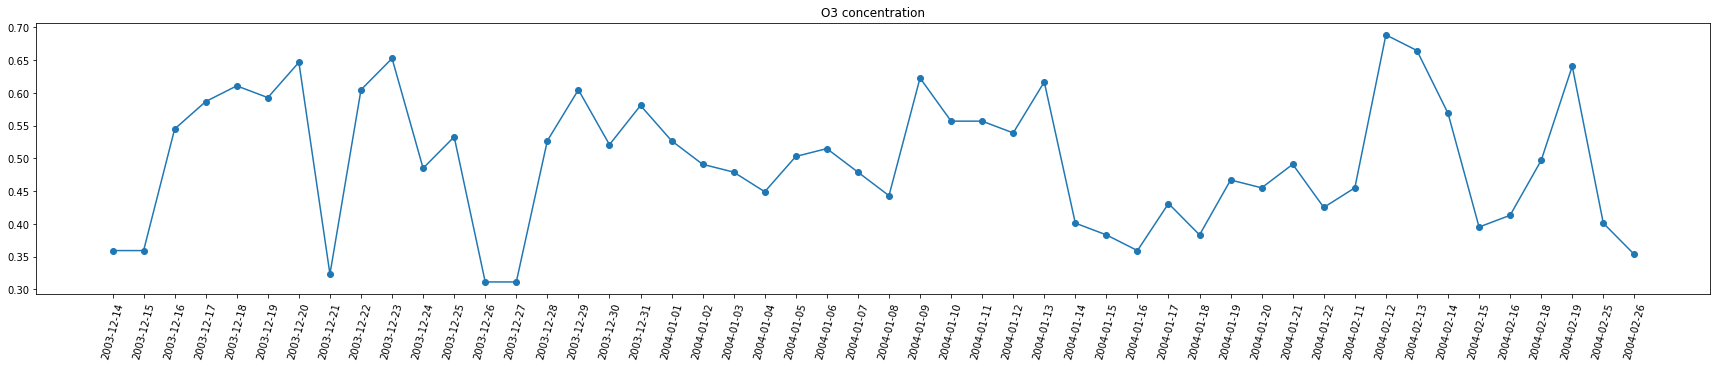

In [3]:
plt.figure(figsize=(30,5))
plt.title("O3 concentration")
plt.plot(df.head(50)['registered_on'],df.head(50)['O3'],'-o')
plt.xticks(rotation=75)
plt.show()

Al observar el gráfico se observa que faltan mediciones, en particular, después del 22 de enero del 2004 viene la medición del 11 de febrero de 2004. Por lo anterior, se prodece a calcular cuanta es la proporción de datos faltantes. Para esto, se agregan los registros de fechas faltantes con NaN.

In [4]:
df.registered_on = pd.to_datetime(df.registered_on, format='%Y-%m-%d')
df.set_index('registered_on',inplace=True)
df = df.resample('D').mean()

In [5]:
"Data faltante  {}%".format(df['O3'].isna().sum()/len(df) * 100)

'Data faltante  65.74132492113564%'

Se observa que la proporción de días que faltan es un 65%, lo cual es bastante elevado. Para continuar con el experimento se probarán distintas maneras se rellenar estos datos faltantes. Antes de comenzar, se genera un resumen para cada columna.

In [6]:
df.describe()

,CO,PM10,PM25,NO,NOX,WD,RH,TEMP,WS,UVA,UVB,O3
count,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000,1629.000000
mean,0.185423,0.129600,0.118716,0.078096,0.143159,0.688165,0.715321,0.552156,0.158919,0.032180,0.033077,0.415092
std,0.084199,0.064871,0.062701,0.062492,0.085842,0.082069,0.140079,0.132291,0.090008,0.031261,0.025226,0.127287
min,0.000000,0.011780,0.003745,0.000147,0.008587,0.000000,0.155555,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.137931,0.094241,0.082397,0.039211,0.091954,0.643123,0.618888,0.482512,0.128617,0.023690,0.028463,0.335329
50%,0.172413,0.117801,0.108614,0.067740,0.130622,0.663091,0.724444,0.569956,0.143259,0.030190,0.034660,0.413174
75%,0.226612,0.148560,0.142322,0.099501,0.169170,0.698589,0.824444,0.636792,0.159043,0.034680,0.037717,0.496634
max,0.700110,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.910180


Se observa que los atributos tienen valores mayores que 0 y menores que 1, donde si se observa el tercer cuartil y el máximo se observa una gran diferencia, lo que indica la posible presencia de outliers en el dataset. Para todos los atributos el valor mínimo es mayor que 0, por lo que rellenar los valores faltantes con 0 no es una buena opción.

c:\mauro\redesn~1\env\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\mauro\redesn~1\env\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


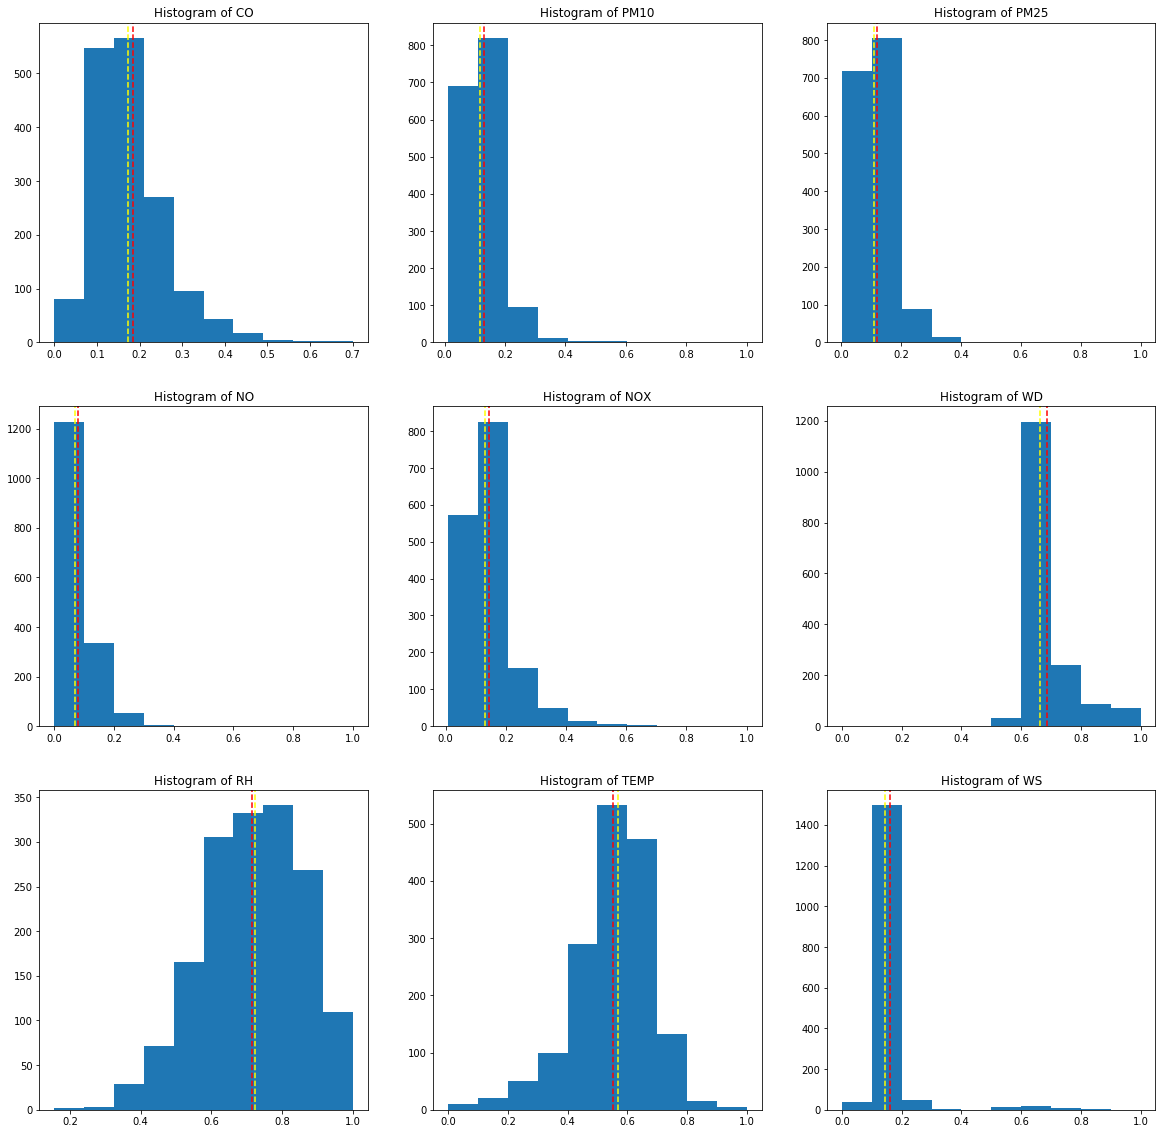

In [7]:
df.head()
plt.figure(figsize=(20,20))
plt.subplot(331)
plt.hist(df.CO)
plt.title("Histogram of CO")
plt.axvline(df['CO'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['CO'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(332)
plt.hist(df.PM10)
plt.title("Histogram of PM10")
plt.axvline(df['PM10'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['PM10'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(333)
plt.hist(df.PM25)
plt.title("Histogram of PM25")
plt.axvline(df['PM25'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['PM25'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(334)
plt.hist(df.NO)
plt.title("Histogram of NO")
plt.axvline(df['NO'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['NO'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(335)
plt.hist(df.NOX)
plt.title("Histogram of NOX")
plt.axvline(df['NOX'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['NOX'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(336)
plt.hist(df.WD)
plt.title("Histogram of WD")
plt.axvline(df['WD'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['WD'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(337)
plt.hist(df.RH)
plt.title("Histogram of RH")
plt.axvline(df['RH'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['RH'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(338)
plt.hist(df.TEMP)
plt.title("Histogram of TEMP")
plt.axvline(df['TEMP'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['TEMP'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.subplot(339)
plt.hist(df.WS)
plt.title("Histogram of WS")
plt.axvline(df['WS'].mean(), color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(df['WS'].median(), color='yellow', linestyle='dashed', linewidth=1.5)
plt.show()

Realizando un histograma para cada atributo, marcando también su media (rojo) y su mediana (amarillo) se ve que ambas medidas de tendencia son similares, por lo que no deberían existir muchas diferencias al rellenar con alguno de estos dos valores, prefiriendo la media dado que es más fácil calcularla. Esta será uno de los métodos con los que se rellenarán los datos. Sin embargo, de existir un rango de datos faltantes continuos muy grande se tendrían muchos datos seguidos con un valor constante, lo que podría no ser del todo bueno. Dado lo anterior, también se rellenarán datos faltantes utilizando una interpolación lineal para los datos faltantes considerando sus puntos contiguos.

In [8]:
df_lineal = df.resample('D').interpolate()

In [9]:
df_mean = df.fillna(df.mean())

In [10]:
df_lineal['registered_on'] = df_lineal.index
df_mean['registered_on'] = df_mean.index

A continuación se puede ver un gráfico de la concentración de O3 en el tiempo, considerando un período donde se cuenta con datos faltantes, para así ver las diferencia entre los dos métodos utilizados.

c:\mauro\redesn~1\env\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


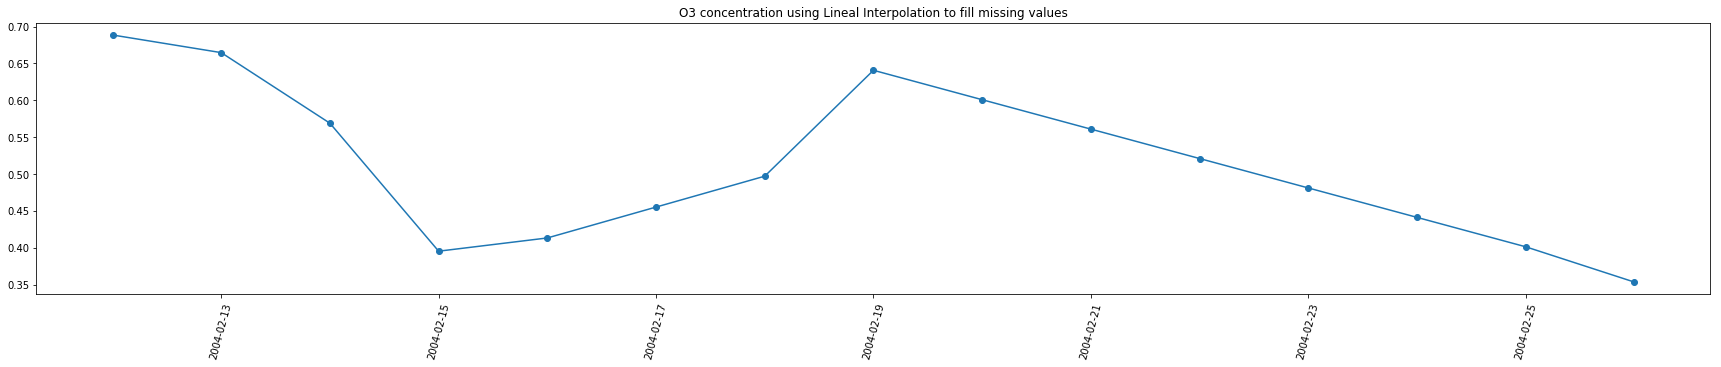

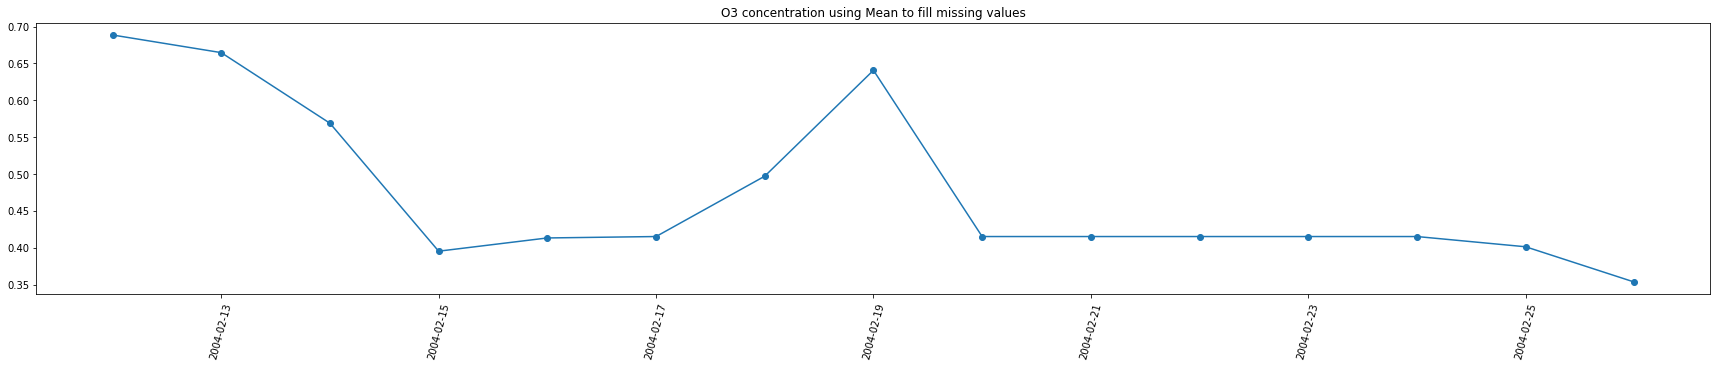

In [11]:
plt.figure(figsize=(30,5))
plt.title("O3 concentration using Lineal Interpolation to fill missing values")
plt.plot(df_lineal['registered_on'][60:75],df_lineal['O3'][60:75],'-o')
plt.xticks(rotation=75)
plt.show()

plt.figure(figsize=(30,5))
plt.title("O3 concentration using Mean to fill missing values")
plt.plot(df_mean['registered_on'][60:75],df_mean['O3'][60:75],'-o')
plt.xticks(rotation=75)
plt.show()

In [12]:
"Data lenght: {}".format(len(df_lineal))

'Data lenght: 4755'

Una vez rellenados los valores faltantes es necesario separar nuestro conjunto de datos en entrenamiento, validación y testing. Se cuenta con 4755 registros, de los cuales se realizará una separación 80 y 20 entre entrenamiento y testing, y sacando un 20% para validación desde el conjunto de entrenamiento. Como nos encontramos analizando series de tiempo, no podemos tomar registros al azar para obtener los 3 conjuntos, por lo que se tomarán secuencialmente.

In [13]:
df_lineal_train = df_lineal[0:3084]
df_lineal_test = df_lineal[3084:4755]
df_mean_train = df_mean[0:3084]
df_mean_test = df_mean[3084:4755]

In [14]:
df_lineal_val = df_lineal_train[2467:3084]
df_lineal_train = df_lineal_train[0:2467]
df_mean_val = df_mean_train[2467:3084]
df_mean_train = df_mean_train[0:2467]


Así cada conjunto queda con la siguiente cantidad de registros.

In [15]:
print("Data lenght in train set: {}".format(len(df_lineal_train)))
print("Data lenght in validation set: {}".format(len(df_lineal_val)))
print("Data lenght in test set: {}".format(len(df_lineal_test)))

Data lenght in train set: 2467
Data lenght in validation set: 617
Data lenght in test set: 1671


In [16]:
df_lineal_train.drop(['registered_on'],axis=1,inplace=True)
df_lineal_val.drop(['registered_on'],axis=1,inplace=True)
df_lineal_test.drop(['registered_on'],axis=1,inplace=True)
df_mean_train.drop(['registered_on'],axis=1,inplace=True)
df_mean_val.drop(['registered_on'],axis=1,inplace=True)
df_mean_test.drop(['registered_on'],axis=1,inplace=True)

c:\mauro\redesn~1\env\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Se procede a escalar los datos, utilizando la media y la desviación estándar de cada atributo. Cada data a utilizar (relleno con interpolación lineal y relleno con media) utilizará su propio escalador. 

In [17]:
matrix_lineal_train = df_lineal_train.values
matrix_lineal_val = df_lineal_val.values
matrix_lineal_test = df_lineal_test.values
matrix_mean_train = df_mean_train.values
matrix_mean_val = df_mean_val.values
matrix_mean_test = df_mean_test.values

In [18]:
lineal_scaler = StandardScaler()
lineal_scaler.fit(matrix_lineal_train)
matrix_lineal_train_scaled = lineal_scaler.transform(matrix_lineal_train)
matrix_lineal_val_scaled = lineal_scaler.transform(matrix_lineal_val)
matrix_lineal_test_scaled = lineal_scaler.transform(matrix_lineal_test)

In [19]:
mean_scaler = StandardScaler()
mean_scaler.fit(matrix_mean_train)
matrix_mean_train_scaled = mean_scaler.transform(matrix_mean_train)
matrix_mean_val_scaled = mean_scaler.transform(matrix_mean_val)
matrix_mean_test_scaled = mean_scaler.transform(matrix_mean_test)

> _**b) Ahora nos gustarı́a manipular los datos, para que hagamos la predicción para el tiempo siguiente usando los valores de los últimos perı́odos de tiempo. El número de perı́odos de tiempos "hacia atrás" que usaremos se denomina lag. Por ejemplo, tendremos un lag igual a 3, si para predecir el valor  $x_{𝑡+1}$  en el tiempo siguiente usamos la información del tiempo actual  $x_t$  y la de los dos perı́odos anteriores  $x_{𝑡−1}$  y  $x_{𝑡−2}$  como variables de entrada. Realice una función que reciba una secuencia de valores y la transforme en dos arreglos dataX (inputs) y dataY (targets), además utilicela para generar los conjuntos de entrenamiento y test para el problema decidiendo el valor del lag.**_

Se crea una función que genere los dataset a utilizar en los siguientes experimentos. Esta considera solo el $O_3$ para crear nuestro input y nuestro output, considerando un parámetro de _lag_, el cual maneja cuantos datos en el pasado se utilizarán para predecir un determinado valor.

Utilizando dicha función, se crean la matriz de inputs para los dos dataset que se utilizarán, para cada conjunto de datos que se utilizarán.

In [71]:
def create_o3_dataset(matrix,lag=1):
    data_x = []
    data_y = []
    
    for output_row_index in range(lag,matrix.shape[0]):
        data_y.append(matrix[output_row_index][11])
        for input_row_index in range(output_row_index-lag,output_row_index):
            data_x.append(matrix[input_row_index][11])
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    data_x = np.reshape(data_x,(-1,lag))
    return data_x, data_y

In [21]:
x_mean_train, y_mean_train = create_o3_dataset(matrix_mean_train_scaled,lag=3)
x_mean_val, y_mean_val = create_o3_dataset(matrix_mean_val_scaled,lag=3)
x_mean_test, y_mean_test = create_o3_dataset(matrix_mean_test_scaled,lag=3)

In [212]:
x_mean_train.shape
x_mean_train[0]

array([[-0.84669413, -0.84669413,  1.43836145]])

In [22]:
x_lineal_train, y_lineal_train = create_o3_dataset(matrix_lineal_train_scaled,lag=3)
x_lineal_val, y_lineal_val = create_o3_dataset(matrix_lineal_val_scaled,lag=3)
x_lineal_test, y_lineal_test = create_o3_dataset(matrix_lineal_test_scaled,lag=3)

> _**c) En estos momentos tenemos nuestros datos en la forma [samples, features]. Sin embargo, la red RNN necesita que los datos se encuentren en un arreglo de tres dimensiones [samples, time steps, features]. Transforme el conjuntos de entrenamiento y de pruebas a la estructura deseada, incorporando el lag como features. Defina dos modelos para comparar, una red recurrente simple y una red convolucional unidimensional (donde el kernel es un vector de largo  𝑤 ), comente sobre las dimensiones/shape de los parámetros de cada una de las redes. Entrene los dos modelos con la nueva representación ¿Qué limitaciones tiene el tamaño/width del kernel de la convolucional?**_

Como la red recurrente considera un input con las siguientes dimensiones [samples, time steps, features] se utiliza la función _reshape_ de _numpy_ para poder dejar los conjuntos de datos definidos en el ítem anterior. Una vez realizado lo anterior, se crean 4 redes, 2 recurrentes y 2 convolucionales, las cuales actuaran en los dos dataset definidos anteriormente.

In [23]:
x_mean_train = np.reshape(x_mean_train,(x_mean_train.shape[0],1,x_mean_train.shape[1]))
x_mean_val = np.reshape(x_mean_val,(x_mean_val.shape[0],1,x_mean_val.shape[1]))
x_mean_test = np.reshape(x_mean_test,(x_mean_test.shape[0],1,x_mean_test.shape[1]))

In [24]:
x_lineal_train = np.reshape(x_lineal_train,(x_lineal_train.shape[0],1,x_lineal_train.shape[1]))
x_lineal_val = np.reshape(x_lineal_val,(x_lineal_val.shape[0],1,x_lineal_val.shape[1]))
x_lineal_test = np.reshape(x_lineal_test,(x_lineal_test.shape[0],1,x_lineal_test.shape[1]))

In [25]:
def get_recurrent_model(lag,input_shape):
    model_rnn = Sequential()
    model_rnn.add(SimpleRNN(units=4,input_shape=input_shape,activation='tanh',return_sequences=False,go_backwards=False))
    model_rnn.add(Dense(1,activation='linear'))
    model_rnn.compile(loss='mean_squared_error',optimizer='adam')
    return model_rnn
    
def get_convolutional_model(kernel_size,input_shape):
    model_cnn = Sequential()
    model_cnn.add(Conv1D(4,kernel_size=kernel_size,input_shape=input_shape,activation='relu',padding='valid'))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(1,activation='linear'))
    model_cnn.compile(loss='mean_squared_error',optimizer='adam')
    return model_cnn

Para el _kernel size_ de la red convolucional se debe utilizar un valor menor que el largo del vector de entrada, el cual en este caso de 3, pues de ser del mismo largo se pierde la gracia de la conectividad local que tienen las redes convolucionales. En este caso, el código proporcionado con la arquitectura de la red convolucional involucra el uso de un padding valido, lo que hace que no se aplique 0-padding y al hacer la "convolución" con el kernel invertido se tenga que calza exactamente con las dimensiones del input. Es por esto que en este caso no se puede usar una _kernel size_ de 2, pues al mover el kernel quedaría una dimensión de este fuera del input al hacer la operación de convolución.

A continuación se presenta la arquitectura a utilizar para las redes recurrentes.

In [26]:
model_rnn_lineal = get_recurrent_model(3,(1,3))
model_rnn_lineal.summary()
rnn_weights = model_rnn_lineal.get_weights()
print("Weight RNN Shapes")
print(np.shape(rnn_weights[0]))
print(np.shape(rnn_weights[1]))
print(np.shape(rnn_weights[2]))
print(np.shape(rnn_weights[3]))
print(np.shape(rnn_weights[4]))

model_rnn_mean = get_recurrent_model(3,(1,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 4)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
Weight RNN Shapes
(3, 4)
(4, 4)
(4,)
(4, 1)
(1,)


Se observa que se tienen dos capas, una de recurrencia con 32 parámetros entrenables y una densa con 5 parámetros entrenables. La capa densa será la que calculará el valor del $O_3$, por lo que utiliza una función de activación lineal. En cambio, la red recurrente utiliza una función de activación tangencial, pues de utilizar una función de activación no-acotada se produciría una explosión del gradiente.

En cuanto a las dimensiones de los parámetros, se tiene primero una matriz de $3x4 = 12$ parámetros, los cuales van a acomodar el input a las 4 neuronas de la capa recurrente. Luego, se tiene una matriz de $4 x 4 = 16$ parámetros, los cuales servirán para el mapeo entre capas ocultas (recordando que una capa recurrente se puede desenrrollar, compartiendo los parámetros entre las capas desenrrolladas). Luego, se tiene un vector de 4 parámetros, los cuales se encargarán de pasar lo calculado por la capa oculta recurrente a la capa densa. Las dos estructuras que quedan, las cuales son un vector de $4x1$ y un solo parámetro corresponden a los pesos y al bias de la capa densa, con los cuales calculará el ozono. En total se tienen 37 parámetros entrenables.



A continuación se presenta la arquitectura de las redes con arquitectura convolucional.

In [27]:
model_cnn_lineal = get_convolutional_model(1,(1,3))
model_cnn_lineal.summary()
cnn_weights = model_cnn_lineal.get_weights()
print("Weight CNN Shapes")
print(np.shape(cnn_weights[0]))
print(np.shape(cnn_weights[1]))
print(np.shape(cnn_weights[2]))
print(np.shape(cnn_weights[3]))
model_cnn_mean = get_convolutional_model(1,(1,3))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1, 4)              16        
_________________________________________________________________
flatten_1 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Weight CNN Shapes
(1, 3, 4)
(4,)
(4, 1)
(1,)


La red convolucional cuenta con 3 capas. La primera es una capa convolucional en una dimensión, la segunda es una capa flatten y la tercera es una capa densa. Como en este caso no hay restricciones para la función de activación se utilizará una función de activación ReLu en la capa convolucional, mientras que se mantendrá la función de activación lineal para la capa densa, pues estamos en un problema que requiere aproximar un output continuo.

Con respecto a los parámetros, primero se tiene un tensor de $1 x 3 x 4 = 12$ parámetros, correspondientes al input de 1 x 3, pero considerando los 4 kernels que utiliza la red. Luego se tiene un vector de cuatro componentes que corresponden a los bias de la capa convolucional. Como la capa de flatten lo único que hace es pasar de un tensor a un vector no cuenta con parámetros, por lo que las siguientes estructuras de parámetros son un vector de $4 x 1$ parámetros de la capa densa, mapeando las 4 componentes del tensor a la neurona que calculará la salida, y además se cuenta con su bias. En total se tienen 21 parámetros entrenables.

In [136]:
model_rnn_lineal.fit(x_lineal_train,y_lineal_train,epochs=25,batch_size=1,verbose=0)
model_rnn_mean.fit(x_mean_train,y_mean_train,epochs=25,batch_size=1,verbose=0)

In [137]:
model_cnn_lineal.fit(x_lineal_train,y_lineal_train,epochs=25,batch_size=1,verbose=0)
model_cnn_mean.fit(x_mean_train,y_mean_train,epochs=25,batch_size=1,verbose=0)

> _**d) Mida desempeño de los dos modelos a través del root mean square error (RMSE) y compare. Para ésto deberá realizar las predicciones sobre el conjunto de entrenamiento y pruebas/validación, recuerde denormalizar los datos para que el error pueda ser computado en la escala original del rango de valores.**_

Se realizan las predicciones para los 4 modelos entrenados (2 recurrentes y 2 convolucionales). Como los datos fueron escalados es necesario desnormalizarlos para mantener la escala real del error en el conjunto de valores. Como el conjunto de outputs se obtuvo a partir de la data ya normalizada es necesario desnormalizarla de igual manera.

In [138]:
#predicciones RNN, dataset con interpolación lineal
rnn_lineal_train_predict = model_rnn_lineal.predict(x_lineal_train,batch_size=1)
rnn_lineal_val_predict = model_rnn_lineal.predict(x_lineal_val,batch_size=1)
rnn_lineal_test_predict = model_rnn_lineal.predict(x_lineal_test,batch_size=1)
#predicciones CNN, dataset con interpolación lineal 
cnn_lineal_train_predict = model_cnn_lineal.predict(x_lineal_train,batch_size=1)
cnn_lineal_val_predict = model_cnn_lineal.predict(x_lineal_val,batch_size=1)
cnn_lineal_test_predict = model_cnn_lineal.predict(x_lineal_test,batch_size=1)

In [139]:
#predicciones RNN, dataset con media
rnn_mean_train_predict = model_rnn_mean.predict(x_mean_train,batch_size=1)
rnn_mean_val_predict = model_rnn_mean.predict(x_mean_val,batch_size=1)
rnn_mean_test_predict = model_rnn_mean.predict(x_mean_test,batch_size=1)
#predicciones CNN, dataset con media
cnn_mean_train_predict = model_cnn_mean.predict(x_mean_train,batch_size=1)
cnn_mean_val_predict = model_cnn_mean.predict(x_mean_val,batch_size=1)
cnn_mean_test_predict = model_cnn_mean.predict(x_mean_test,batch_size=1)


Como para escalar se utilizaron todas las columnas del dataset inicial, no es posible utilizar el escalador de _sklearn_ instanciado anteriormente, por lo que a partir de estos se obtienen la media y la desviación estándar y se procede a desnormalizar a mano de la siguiente manera.

$$x = \mu + \sigma \cdot z$$

In [140]:
lineal_std = lineal_scaler.scale_[-1]
lineal_mean = lineal_scaler.mean_[-1]
mean_std = mean_scaler.scale_[-1]
mean_mean = mean_scaler.mean_[-1]

In [141]:
#Desnormalización de las predicciones, interpolación lineal
rnn_lineal_train_predict = (rnn_lineal_train_predict * lineal_std) + lineal_mean
rnn_lineal_val_predict = (rnn_lineal_val_predict * lineal_std) + lineal_mean
rnn_lineal_test_predict = (rnn_lineal_test_predict * lineal_std) + lineal_mean

cnn_lineal_train_predict = (cnn_lineal_train_predict * lineal_std) + lineal_mean
cnn_lineal_val_predict = (cnn_lineal_val_predict * lineal_std) + lineal_mean
cnn_lineal_test_predict = (cnn_lineal_test_predict * lineal_std) + lineal_mean

In [142]:
#Desrnomalización de las predicciones, media
rnn_mean_train_predict = (rnn_mean_train_predict * mean_std) + mean_mean
rnn_mean_val_predict = (rnn_mean_val_predict * mean_std) + mean_mean
rnn_mean_test_predict = (rnn_mean_test_predict * mean_std) + mean_mean

cnn_mean_train_predict = (cnn_mean_train_predict * mean_std) + mean_mean
cnn_mean_val_predict = (cnn_mean_val_predict * mean_std) + mean_mean
cnn_mean_test_predict = (cnn_mean_test_predict * mean_std) + mean_mean

In [143]:
#Desnormalización Y, interpolacion lineal
y_lineal_train_desn = (y_lineal_train * lineal_std) + lineal_mean
y_lineal_val_desn = (y_lineal_val * lineal_std) + lineal_mean
y_lineal_test_desn = (y_lineal_test * lineal_std) + lineal_mean
#media
y_mean_train_desn = (y_mean_train * mean_std) + mean_mean
y_mean_val_desn = (y_mean_val * mean_std) + mean_mean
y_mean_test_desn = (y_mean_test * mean_std) + mean_mean

Finalmente se calcula el Root Mean Squared Error para cada red entrenada, considerando los conjuntos de entrenamiento, validación y testing.

In [144]:
rnn_lineal_train_score = math.sqrt(mean_squared_error(y_lineal_train_desn, rnn_lineal_train_predict))
print('RNN Train Score on lineal set: %.4f RMSE' % (rnn_lineal_train_score))
rnn_lineal_val_score = math.sqrt(mean_squared_error(y_lineal_val_desn, rnn_lineal_val_predict))
print('RNN Val Score on lineal set: %.4f RMSE' % (rnn_lineal_val_score))
rnn_lineal_test_score = math.sqrt(mean_squared_error(y_lineal_test_desn, rnn_lineal_test_predict))
print('RNN Test Score on lineal set: %.4f RMSE' % (rnn_lineal_test_score))

RNN Train Score on lineal set: 0.0726 RMSE
RNN Val Score on lineal set: 0.0689 RMSE
RNN Test Score on lineal set: 0.0519 RMSE


In [145]:
cnn_lineal_train_score = math.sqrt(mean_squared_error(y_lineal_train_desn, cnn_lineal_train_predict))
print('CNN Train Score on lineal set: %.4f RMSE' % (cnn_lineal_train_score))
cnn_lineal_val_score = math.sqrt(mean_squared_error(y_lineal_val_desn, cnn_lineal_val_predict))
print('CNN Val Score on lineal set: %.4f RMSE' % (cnn_lineal_val_score))
cnn_lineal_test_score = math.sqrt(mean_squared_error(y_lineal_test_desn, cnn_lineal_test_predict))
print('CNN Test Score on lineal set: %.4f RMSE' % (cnn_lineal_test_score))

CNN Train Score on lineal set: 0.0721 RMSE
CNN Val Score on lineal set: 0.0685 RMSE
CNN Test Score on lineal set: 0.0514 RMSE


Considerando el dataset con relleno basado en interpolación lineal se obtienen resultados bastantes similares entre las dos redes, donde la red convolucional obtiene resultados ligeramente superiores a la red recurrente.

In [146]:
rnn_mean_train_score = math.sqrt(mean_squared_error(y_mean_train_desn, rnn_mean_train_predict))
print('RNN Train Score on mean set: %.4f RMSE' % (rnn_mean_train_score))
rnn_mean_val_score = math.sqrt(mean_squared_error(y_mean_val_desn, rnn_mean_val_predict))
print('RNN Val Score on mean set: %.4f RMSE' % (rnn_mean_val_score))
rnn_mean_test_score = math.sqrt(mean_squared_error(y_mean_test_desn, rnn_mean_test_predict))
print('RNN Test Score on mean set: %.4f RMSE' % (rnn_mean_test_score))

RNN Train Score on mean set: 0.0708 RMSE
RNN Val Score on mean set: 0.0669 RMSE
RNN Test Score on mean set: 0.0557 RMSE


In [147]:
cnn_mean_train_score = math.sqrt(mean_squared_error(y_mean_train_desn, cnn_mean_train_predict))
print('CNN Train Score on mean set: %.4f RMSE' % (cnn_mean_train_score))
cnn_mean_val_score = math.sqrt(mean_squared_error(y_mean_val_desn, cnn_mean_val_predict))
print('CNN Val Score on mean set: %.4f RMSE' % (cnn_mean_val_score))
cnn_mean_test_score = math.sqrt(mean_squared_error(y_mean_test_desn, cnn_mean_test_predict))
print('CNN Test Score on mean set: %.4f RMSE' % (cnn_mean_test_score))

CNN Train Score on mean set: 0.0715 RMSE
CNN Val Score on mean set: 0.0646 RMSE
CNN Test Score on mean set: 0.0541 RMSE


Considerando ahora el dataset donde se utilizó la media de los datos para los valores faltantes, se obtienen mejores resultados en la recurrente en entrenamiento, mas no en validación y training. 

En general las diferencias son muy pequeñas entre ambas redes, y entre ambos dataset. Por lo que se continuará trabajando con el dataset con la interpolación lineal.

> _**e) Grafique las predicciones del conjunto de entrenamiento y pruebas/validación, y contrástelas con la serie de tiempo original. Muestre un extracto de la predicción para ver en mas detalle cómo es la predicción del modelo, comente.**_

Se grafica las predicciones realizadas por las cuatro redes, en conjunto a la serie de tiempo original, para los conjuntos de entrenamiento, validación y testing. Como se cuenta con una cantidad elevada de datos por cada conjunto como para graficarlos todos, se consideran 50 puntos para cada conjunto, procurando que se encuentre la mayor cantidad de datos originales y no de los rellenados.

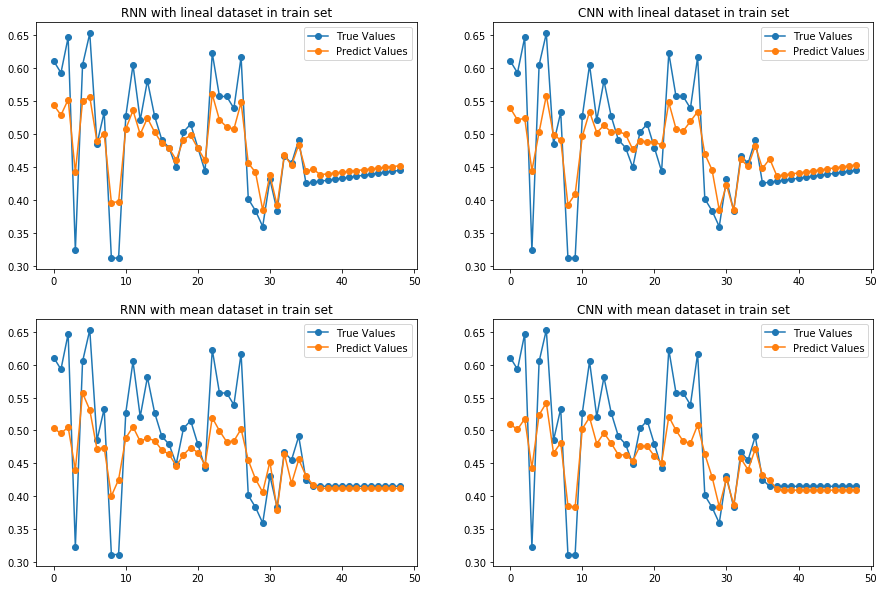

In [148]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.title("RNN with lineal dataset in train set")
plt.plot(y_lineal_train_desn[1:50],'-o')
plt.plot(rnn_lineal_train_predict[2:51],'-o')
plt.legend(['True Values','Predict Values'])
plt.subplot(222)
plt.title("CNN with lineal dataset in train set")
plt.plot(y_lineal_train_desn[1:50],'-o')
plt.plot(cnn_lineal_train_predict[2:51],'-o')
plt.legend(['True Values','Predict Values'])
plt.subplot(223)
plt.title("RNN with mean dataset in train set")
plt.plot(y_mean_train_desn[1:50],'-o')
plt.plot(rnn_mean_train_predict[2:51],'-o')
plt.legend(['True Values','Predict Values'])
plt.subplot(224)
plt.title("CNN with mean dataset in train set")
plt.plot(y_mean_train_desn[1:50],'-o')
plt.plot(cnn_mean_train_predict[2:51],'-o')
plt.legend(['True Values','Predict Values'])
plt.show()

Se observa que el comportamiento de ambos tipos de redes es similar, al menos para el conjunto de entrenamiento. Al comparar entre dataset, se observa que las redes entrenadas con el dataset bajo interpolación lineal obtienen ligeramente mejores resultados, sobretodo en los "spikes" de la serie de tiempo original.

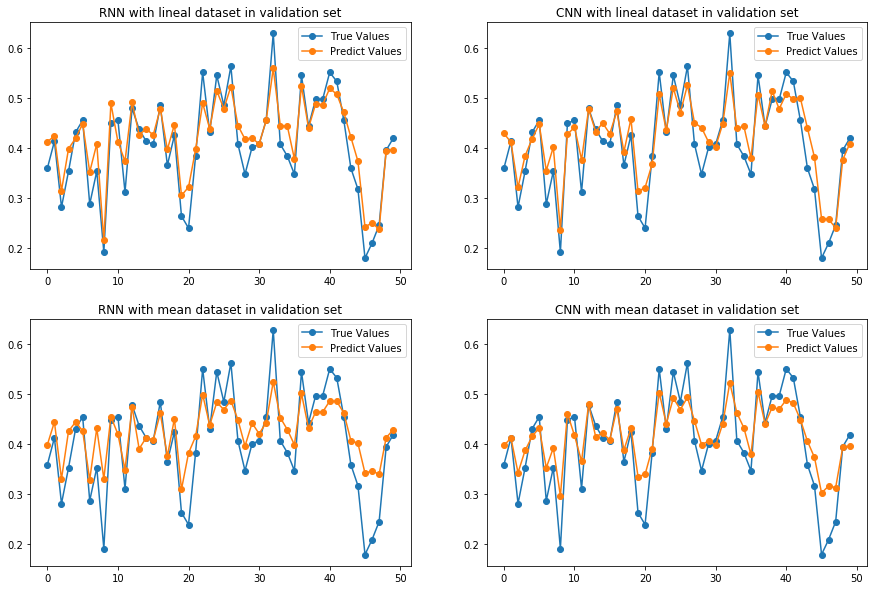

In [149]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.title("RNN with lineal dataset in validation set")
plt.plot(y_lineal_val_desn[100:150],'-o')
plt.plot(rnn_lineal_val_predict[101:151],'-o')
plt.legend(['True Values','Predict Values'])
plt.subplot(222)
plt.title("CNN with lineal dataset in validation set")
plt.plot(y_lineal_val_desn[100:150],'-o')
plt.plot(cnn_lineal_val_predict[101:151],'-o')
plt.legend(['True Values','Predict Values'])
plt.subplot(223)
plt.title("RNN with mean dataset in validation set")
plt.plot(y_mean_val_desn[100:150],'-o')
plt.plot(rnn_mean_val_predict[101:151],'-o')
plt.legend(['True Values','Predict Values'])
plt.subplot(224)
plt.title("CNN with mean dataset in validation set")
plt.plot(y_mean_val_desn[100:150],'-o')
plt.plot(cnn_mean_val_predict[101:151],'-o')
plt.legend(['True Values','Predict Values'])
plt.show()

En el conjunto de validación se observan resultados similares que en el caso del conjunto de entrenamiento. Sin embargo acá se logran ver situaciones en la que la red recurrente es mejor que la red convolucional para el dataset lineal, aumque por un margen muy bajo. Al comparar entre dataset, ahora es más notorio una mejor desempeño en el dataset lineal, el cual se evidencia en las caídas que presenta la serie de tiempo origindal, donde las redes entrenadas con el dataset lineal captan mejor dicha información.

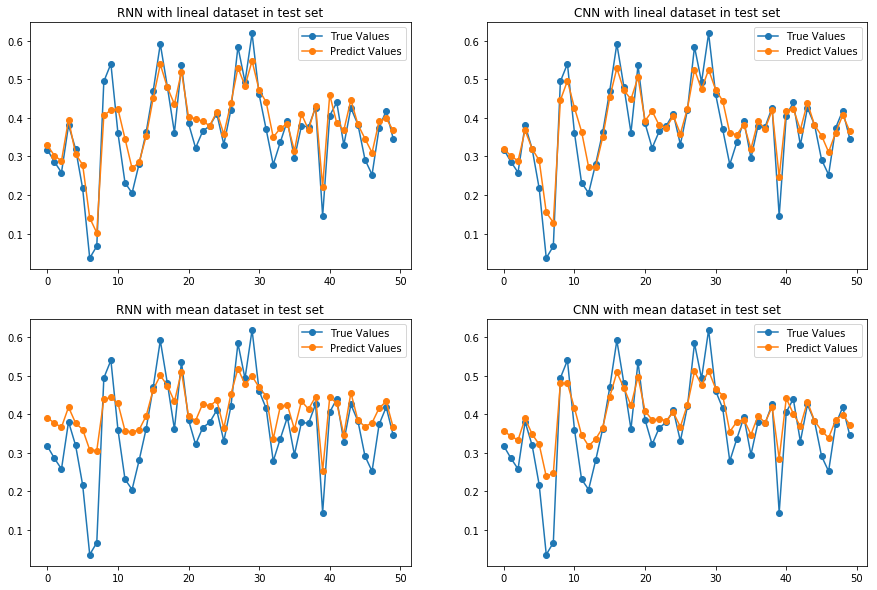

In [150]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.title("RNN with lineal dataset in test set")
plt.plot(y_lineal_test_desn[200:250],'-o')
plt.plot(rnn_lineal_test_predict[201:251],'-o')
plt.legend(['True Values','Predict Values'])
plt.subplot(222)
plt.title("CNN with lineal dataset in test set")
plt.plot(y_lineal_test_desn[200:250],'-o')
plt.plot(cnn_lineal_test_predict[201:251],'-o')
plt.legend(['True Values','Predict Values'])
plt.subplot(223)
plt.title("RNN with mean dataset in test set")
plt.plot(y_mean_test_desn[200:250],'-o')
plt.plot(rnn_mean_test_predict[201:251],'-o')
plt.legend(['True Values','Predict Values'])
plt.subplot(224)
plt.title("CNN with mean dataset in test set")
plt.plot(y_mean_test_desn[200:250],'-o')
plt.plot(cnn_mean_test_predict[201:251],'-o')
plt.legend(['True Values','Predict Values'])
plt.show()

En el conjunto de pruebas se obtiene resultados muy similares a los obtenidos en el conjunto de validación, donde están presentes las mismas características entre redes y entre datasets.

> _**f) En lugar de aumentar el número de dimensiones como el el paso c), entrene la red con un timestep=lag y con dimensión de entrada = 1. Compare y comente sobre el cambio de dimensiones y número de parámetros de las redes ¿Cuál tipo de red tiene más parámetros y porqué? ¿Se produce una mejora del error de entrenamiento y pruebas? ¿Los tiempos de computación son comparables? Comente brevemente sobre cuál es la forma correcta para aprovechar la información a través del tiempo, si con esta forma o la realizada en el paso e).**_

In [81]:
xf_lineal_train, yf_lineal_train = create_o3_dataset(matrix_lineal_train_scaled,lag=3)
xf_lineal_val, yf_lineal_val = create_o3_dataset(matrix_lineal_val_scaled,lag=3)
xf_lineal_test, yf_lineal_test = create_o3_dataset(matrix_lineal_test_scaled,lag=3)

In [82]:
xf_lineal_train = np.reshape(xf_lineal_train,(xf_lineal_train.shape[0],xf_lineal_train.shape[1],1))
xf_lineal_val = np.reshape(xf_lineal_val,(xf_lineal_val.shape[0],xf_lineal_val.shape[1],1))
xf_lineal_test = np.reshape(xf_lineal_test,(xf_lineal_test.shape[0],xf_lineal_test.shape[1],1))

In [250]:
model_rnn2_lineal = get_recurrent_model(3,(3,1))
model_rnn2_lineal.summary()
pesos = model_rnn2_lineal.get_weights()
for i in pesos:
    print(i.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_23 (SimpleRNN)    (None, 4)                 24        
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 5         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________
(1, 4)
(4, 4)
(4,)
(4, 1)
(1,)


In [237]:
model_rnn2_lineal.fit(xf_lineal_train,y_lineal_train,epochs=25,batch_size=1,verbose=0)

In [238]:
model_cnn2_lineal = get_convolutional_model(3,(3,1))
model_cnn2_lineal.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_20 (Conv1D)           (None, 1, 4)              16        
_________________________________________________________________
flatten_20 (Flatten)         (None, 4)                 0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 5         
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [239]:
model_cnn2_lineal.fit(xf_lineal_train,y_lineal_train,epochs=25,batch_size=1,verbose=0)

In [240]:
#Predict RNN
rnn2_train_predict = model_rnn2_lineal.predict(xf_lineal_train)
rnn2_val_predict = model_rnn2_lineal.predict(xf_lineal_val)
rnn2_test_predict = model_rnn2_lineal.predict(xf_lineal_test)

In [241]:
#Predict CNN
cnn2_train_predict = model_cnn2_lineal.predict(xf_lineal_train)
cnn2_val_predict = model_cnn2_lineal.predict(xf_lineal_val)
cnn2_test_predict = model_cnn2_lineal.predict(xf_lineal_test)

In [242]:
def desnormalizar(std,mean,vector):
    return (vector * std) + mean

In [243]:
#Desnormalizar RNN
rnn2_train_predict = desnormalizar(lineal_std,lineal_mean,rnn2_train_predict)
rnn2_val_predict = desnormalizar(lineal_std,lineal_mean,rnn2_val_predict)
rnn2_test_predict = desnormalizar(lineal_std,lineal_mean,rnn2_test_predict)
#Desnormalizar CNN
cnn2_train_predict = desnormalizar(lineal_std,lineal_mean,cnn2_train_predict)
cnn2_val_predict = desnormalizar(lineal_std,lineal_mean,cnn2_val_predict)
cnn2_test_predict = desnormalizar(lineal_std,lineal_mean,cnn2_test_predict)


In [244]:
rnn2_train_score = math.sqrt(mean_squared_error(y_lineal_train_desn, rnn2_train_predict))
print('RNN Train Score on lineal set: %.2f RMSE' % (rnn2_train_score))
rnn2_val_score = math.sqrt(mean_squared_error(y_lineal_val_desn, rnn2_val_predict))
print('RNN Val Score on lineal set: %.2f RMSE' % (rnn2_val_score))
rnn2_test_score = math.sqrt(mean_squared_error(y_lineal_test_desn, rnn2_test_predict))
print('RNN Test Score on lineal set: %.2f RMSE' % (rnn2_test_score))

RNN Train Score on lineal set: 0.07 RMSE
RNN Val Score on lineal set: 0.07 RMSE
RNN Test Score on lineal set: 0.05 RMSE


In [245]:
cnn2_train_score = math.sqrt(mean_squared_error(y_lineal_train_desn, cnn2_train_predict))
print('CNN Train Score on lineal set: %.2f RMSE' % (cnn2_train_score))
cnn2_val_score = math.sqrt(mean_squared_error(y_lineal_val_desn, cnn2_val_predict))
print('CNN Val Score on lineal set: %.2f RMSE' % (cnn2_val_score))
cnn2_test_score = math.sqrt(mean_squared_error(y_lineal_test_desn, cnn2_test_predict))
print('CNN Test Score on lineal set: %.2f RMSE' % (cnn2_test_score))

CNN Train Score on lineal set: 0.08 RMSE
CNN Val Score on lineal set: 0.07 RMSE
CNN Test Score on lineal set: 0.06 RMSE


> _**g) Compare el desempeño de ambos modelos al variar el lag definido en c), recuerde que puede variarlo entre $1$ y  $T_{max}$ . Comente brevemente sobre qué resulta mejor, el tener más información para predecir o si ésto satura la predicción por el efecto del gradiente desvaneciente ¿Ésto ocurre sólo con el modelo recurrente o con el convolucional también? ¿Por qué?**_


<hr style="height:2px;border:none"/>

In [ ]:
lag_list = [x for x in range(1,110,10)]
rnn_hist_list = []
cnn_hist_list = []
rnn_model_list = []
cnn_model_list = []
for lag in lag_list:
    #Create Dataset
    x_train, y_train = create_o3_dataset(matrix_lineal_train_scaled,lag=lag)
    x_val, y_val = create_o3_dataset(matrix_lineal_val_scaled,lag=lag)
    x_train = np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
    x_val = np.reshape(x_val,(x_val.shape[0],1,x_val.shape[1]))
    
    #Get Models
    rnn_model_lag = get_recurrent_model(lag,(1,lag))
    cnn_model_lag = get_convolutional_model(1,(1,lag))
    #Fit and save history
    rnn_hist_list.append(rnn_model_lag.fit(x_train,y_train,batch_size=1,epochs=25,verbose=0,validation_data=(x_val,y_val)))
    cnn_hist_list.append(cnn_model_lag.fit(x_train,y_train,batch_size=1,epochs=25,verbose=0,validation_data=(x_val,y_val)))
    rnn_model_list.append(rnn_model_lag)
    cnn_model_list.append(cnn_model_lag)

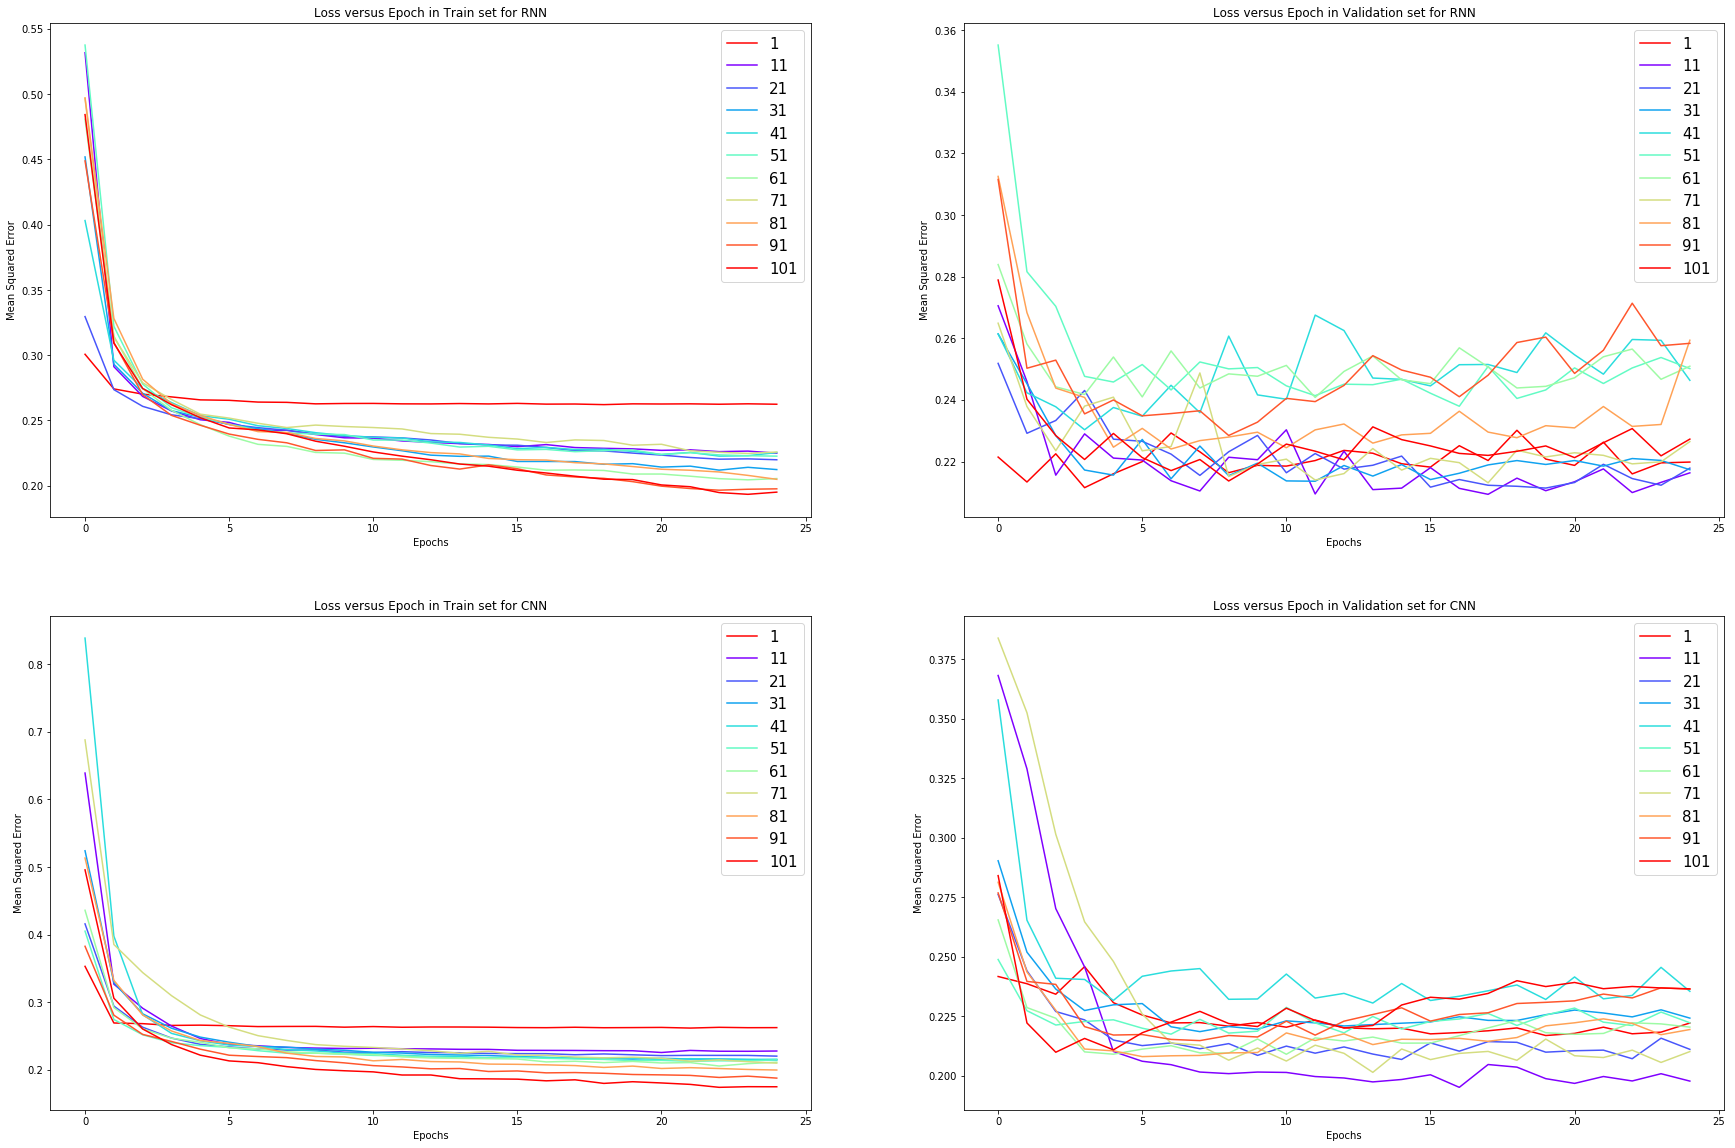

In [267]:
color_map = plt.cm.rainbow(np.linspace(0,1,10))

plt.figure(figsize=(30,20))
plt.subplot(221)
plt.title("Loss versus Epoch in Train set for RNN")
for i in range(len(rnn_hist_list)):
    plt.plot(rnn_hist_list[i].history['loss'],c=color_map[i-1])
plt.legend(lag_list,prop={'size':15})
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.subplot(222)
plt.title("Loss versus Epoch in Validation set for RNN")
for i in range(len(rnn_hist_list)):
    plt.plot(rnn_hist_list[i].history['val_loss'],c=color_map[i-1])
plt.legend(lag_list,prop={'size':15})
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.subplot(223)
plt.title("Loss versus Epoch in Train set for CNN")
for i in range(len(cnn_hist_list)):
    plt.plot(cnn_hist_list[i].history['loss'],c=color_map[i-1])
plt.legend(lag_list,prop={'size':15})
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.subplot(224)
plt.title("Loss versus Epoch in Validation set for CNN")
for i in range(len(cnn_hist_list)):
    plt.plot(cnn_hist_list[i].history['val_loss'],c=color_map[i-1])
plt.legend(lag_list,prop={'size':15})
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.show()


> _**h) Como habrá notado, si usa una ventana de tiempo/timesteps muy larga ($T$ grande), las redes tienen dificultades para aprender. Para abordar este problema se le pide experimentar con la siguiente idea: dividir una secuencia de largo $T$ en trozos de largo 𝐾 y representarla como una matriz de $T/K$ columnas (asumamos que $T$ es un múltiplo de $K$) y $K$ filas, y entrenar la red para procesar la secuencia formada las columnas de esa matriz. De este modo, la red debe aprender dependencias temporales más cortas (largo $T/K$ en vez de $T$), pero accede a toda la información original en forma de atributos ($K$). Llamaremos a esta idea “time folding”. Se le recomienda usar un valor de $K$ que tenga sentido en el problema (por ejemplo $K=7$ representaría una semana). Defina y entrene los modelos para ésta nueva representación.
¿Cómo se ven afectados los modelos?**_

> _**k) Agregue las otras mediciones como nuevos valores de entrada al modelo definido en f), por lo que ahora se transforma la serie de tiempo a N-Dimensional, se tiene un timestep=lag con un features= mediciones nuevas + Ozono. Defina los nuevos modelos con el mejor lag encontrado en g).**_

(samples x timestep x atributtes + o3)

In [235]:
def create_all_dataset(matrix,lag):
    x_lag, y_train = create_o3_dataset(matrix,lag)
    data_x = []
    data_y = []
    for output_row_index in range(lag,matrix.shape[0]):
        data_y.append(matrix[output_row_index][11])
        for input_row_index in range(output_row_index-lag,output_row_index):
             data_x.append(matrix[input_row_index])   
    data_x = np.array(data_x)
    data_y = np.array(data_y)
    data_x = np.reshape(data_x,(matrix.shape[0] - lag,lag,matrix.shape[1]))
    #data_x = np.reshape(data_x,(-1,lag,))
    return data_x, data_y

    

In [268]:
x_train_all, y_train_all = create_all_dataset(matrix_lineal_train_scaled,11)
x_val_all, y_val_all = create_all_dataset(matrix_lineal_val_scaled,11)
x_test_all, y_test_all = create_all_dataset(matrix_lineal_test_scaled,11)

In [269]:
model_rnn_3 = get_recurrent_model(11,(x_train_all.shape[1],x_train_all.shape[2]))
model_rnn_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_24 (SimpleRNN)    (None, 4)                 68        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 5         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [270]:
model_cnn_3 = get_convolutional_model(1,(x_train_all.shape[1],x_train_all.shape[2]))
model_cnn_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 11, 4)             52        
_________________________________________________________________
flatten_21 (Flatten)         (None, 44)                0         
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 45        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


> _**l) Entrene los modelos ¿Se observan los mismos resultados? ¿Las mediciones incorporadas como información adicional ayudan al modelo? Comente y compare.**_

In [279]:
hist_rnn_3 = model_rnn_3.fit(x_train_all,y_train_all,batch_size=1,epochs=25,verbose=0,validation_data=(x_val_all,y_val_all))

In [280]:
hist_cnn_3 = model_cnn_3.fit(x_train_all,y_train_all,batch_size=1,epochs=25,verbose=0,validation_data=(x_val_all,y_val_all))

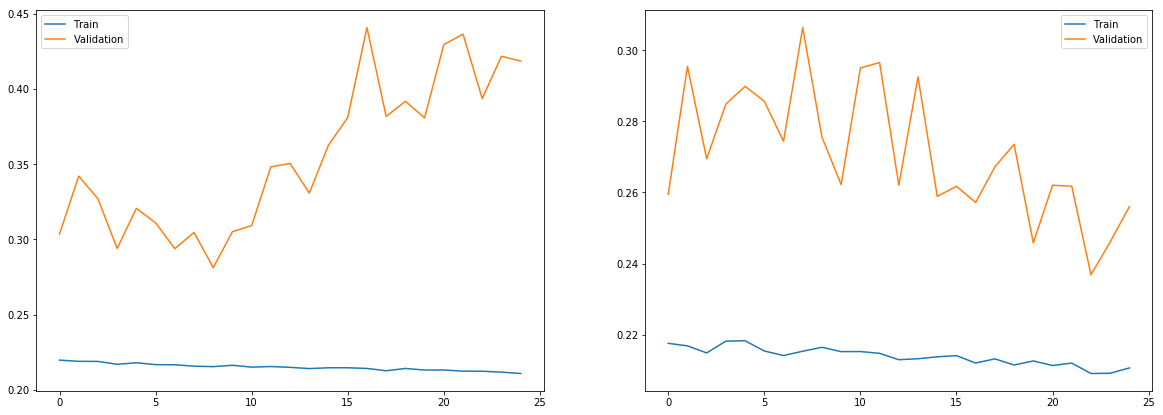

In [281]:
plt.figure(figsize=(20,7))
plt.subplot(121)
plt.plot(hist_rnn_3.history['loss'])
plt.plot(hist_rnn_3.history['val_loss'])
plt.legend(['Train','Validation'])
plt.subplot(122)
plt.plot(hist_cnn_3.history['loss'])
plt.plot(hist_cnn_3.history['val_loss'])
plt.legend(['Train','Validation'])
plt.show()

In [283]:
#RNN Predict
x3_rnn_train_predict = model_rnn_3.predict(x_train_all) 
x3_rnn_val_predict = model_rnn_3.predict(x_val_all)
x3_rnn_test_predict = model_rnn_3.predict(x_test_all)
#CNN Predict
x3_cnn_train_predict = model_cnn_3.predict(x_train_all)
x3_cnn_val_predict = model_cnn_3.predict(x_val_all)
x3_cnn_test_predict = model_cnn_3.predict(x_test_all)
#std, mean, data

In [284]:
y_train_all_desn = desnormalizar(lineal_std,lineal_mean,y_train_all)
y_train_all_vall_desn = desnormalizar(lineal_std,lineal_mean,y_train_all)
y_train_all:_desn = desnormalizar(lineal_std,lineal_mean,y_train_all)
#RNN Desn
x3_rnn_train_predict = desnormalizar(lineal_std,lineal_mean,x3_rnn_train_predict)
x3_rnn_val_predict = desnormalizar(lineal_std,lineal_mean,x3_rnn_val_predict)
x3_rnn_test_predict = desnormalizar(lineal_std,lineal_mean,x3_rnn_test_predict)
#CNN Desn
x3_cnn_train_predict = desnormalizar(lineal_std,lineal_mean,x3_cnn_train_predict)
x3_cnn_val_predict = desnormalizar(lineal_std,lineal_mean,x3_cnn_val_predict)
x3_cnn_test_predict = desnormalizar(lineal_std,lineal_mean,x3_cnn_test_predict)

In [285]:
rnn3_train_score = math.sqrt(mean_squared_error(y_train_all_desn, x3_rnn_train_predict))
print('RNN Train Score on lineal set: %.2f RMSE' % (rnn3_train_score))
rnn3_val_score = math.sqrt(mean_squared_error(y_train_all_desn, x3_rnn_val_predict))
print('RNN Val Score on lineal set: %.2f RMSE' % (rnn3_val_score))
rnn3_test_score = math.sqrt(mean_squared_error(y_train_all_desn, x3_rnn_test_predict))
print('RNN Test Score on lineal set: %.2f RMSE' % (rnn3_test_score))

RNN Train Score on lineal set: 0.07 RMSE


ValueError: Found input variables with inconsistent numbers of samples: [2456, 606]

In [ ]:
cnn3_train_score = math.sqrt(mean_squared_error(y_train_all_desn, x3_cnn_train_predict))
print('CNN Train Score on lineal set: %.2f RMSE' % (cnn3_train_score))
cnn3_val_score = math.sqrt(mean_squared_error(y_train_all_desn, x3_cnn_val_predict))
print('CNN Val Score on lineal set: %.2f RMSE' % (cnn3_val_score))
cnn3_test_score = math.sqrt(mean_squared_error(y_train_all_desn, x3_cnn_test_predict))
print('CNN Test Score on lineal set: %.2f RMSE' % (cnn3_test_score))